# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

Load feature names.

In [2]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


**(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].**

--------------------------------------------------------------------------------


explained variance by principal component analysis
-----------------------------------
    k |   explained variance
-----------------------------------
    1 |       0.164043312793
    2 |       0.297278101488
    3 |       0.399012666709
    4 |       0.469646231059
    5 |       0.508312694566
    6 |       0.545120737641
    7 |       0.576403128668
    8 |       0.603740502195
    9 |       0.629905406884
   10 |       0.652214832563
   11 |       0.672696562099
   12 |        0.69137986869
   13 |        0.70872408902
   14 |       0.725567695477
   15 |       0.740755883424
   16 |       0.755842067705
   17 |       0.770133402741
   18 |       0.784253529053
   19 |       0.797503976447
   20 |       0.808967765956
   21 |       0.819678424424
   22 |       0.830335890867
   23 |       0.840745562597
   24 |       0.850682547861
   25 |       0.859763246507
   26 |        0.86845650881
   27 |    

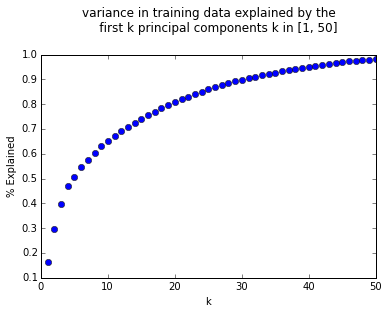

In [4]:
def P1():
### STUDENT START ###
    explained_var = []

    print "-" * 80
    print "\n"
    print "explained variance by principal component analysis"
    
    print "-" * 35
    print "%5s | %20s" % ("k", "explained variance")
    print "-" * 35

    # iterate through first k principal components for k in [1, 50]
    for k in range(1, 51):
        # fit PCA
        pca = PCA(n_components = k)
        pca.fit(train_data, train_labels)

        # calculate the total explained variance by aggregating 
        # additionally explained variance by each k
        explained_var.append(sum(pca.explained_variance_ratio_))

        print "%5s | %20s" % (str(k), str(sum(pca.explained_variance_ratio_)) )

    plt.plot(range(1,51), explained_var,'bo')
    plt.title('variance in training data explained by the \n \
    first k principal components k in [1, 50]', y = 1.08)
    plt.xlabel('k')
    plt.ylabel('% Explained')

### STUDENT END ###

P1()

**(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html**

--------------------------------------------------------------------------------
shape of training data: (7000, 126)
shape of data after reducing dimensions to 2: (7000, 2)


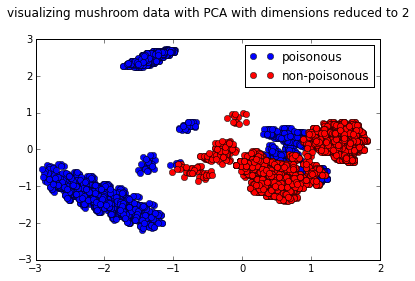

In [5]:
def P2():
### STUDENT START ###
    print "-" * 80

    # define global to use in later problems
    global pca
    global pca_train
    global poison
    global not_poison
    
    # fit PCA for 2 dimensions
    pca = PCA(n_components=2)
    pca.fit(train_data)
    
    print "shape of training data: {}".format(str(train_data.shape))

    # apply dimension reduction on train data
    pca_train = pca.transform(train_data)

    print "shape of data after reducing dimensions to 2: {}".format(str(pca_train.shape))
    
    # subset into poisonous and non-poisonous cases
    poison = pca_train[train_labels == 1]
    not_poison = pca_train[train_labels == 0]

    # plot poisonous in blue and non-poisonous in red
    plt.plot(poison[:, 0], poison[:, 1], 'bo', label = "poisonous")
    plt.plot(not_poison[:, 0], not_poison[:, 1], 'ro', label = "non-poisonous")
    plt.title('visualizing mushroom data with PCA with dimensions reduced to 2', y=1.08)
    plt.rcParams['legend.loc'] = 'best'
    plt.legend()
    plt.tight_layout()
    plt.show()

### STUDENT END ###

P2()

**(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.**

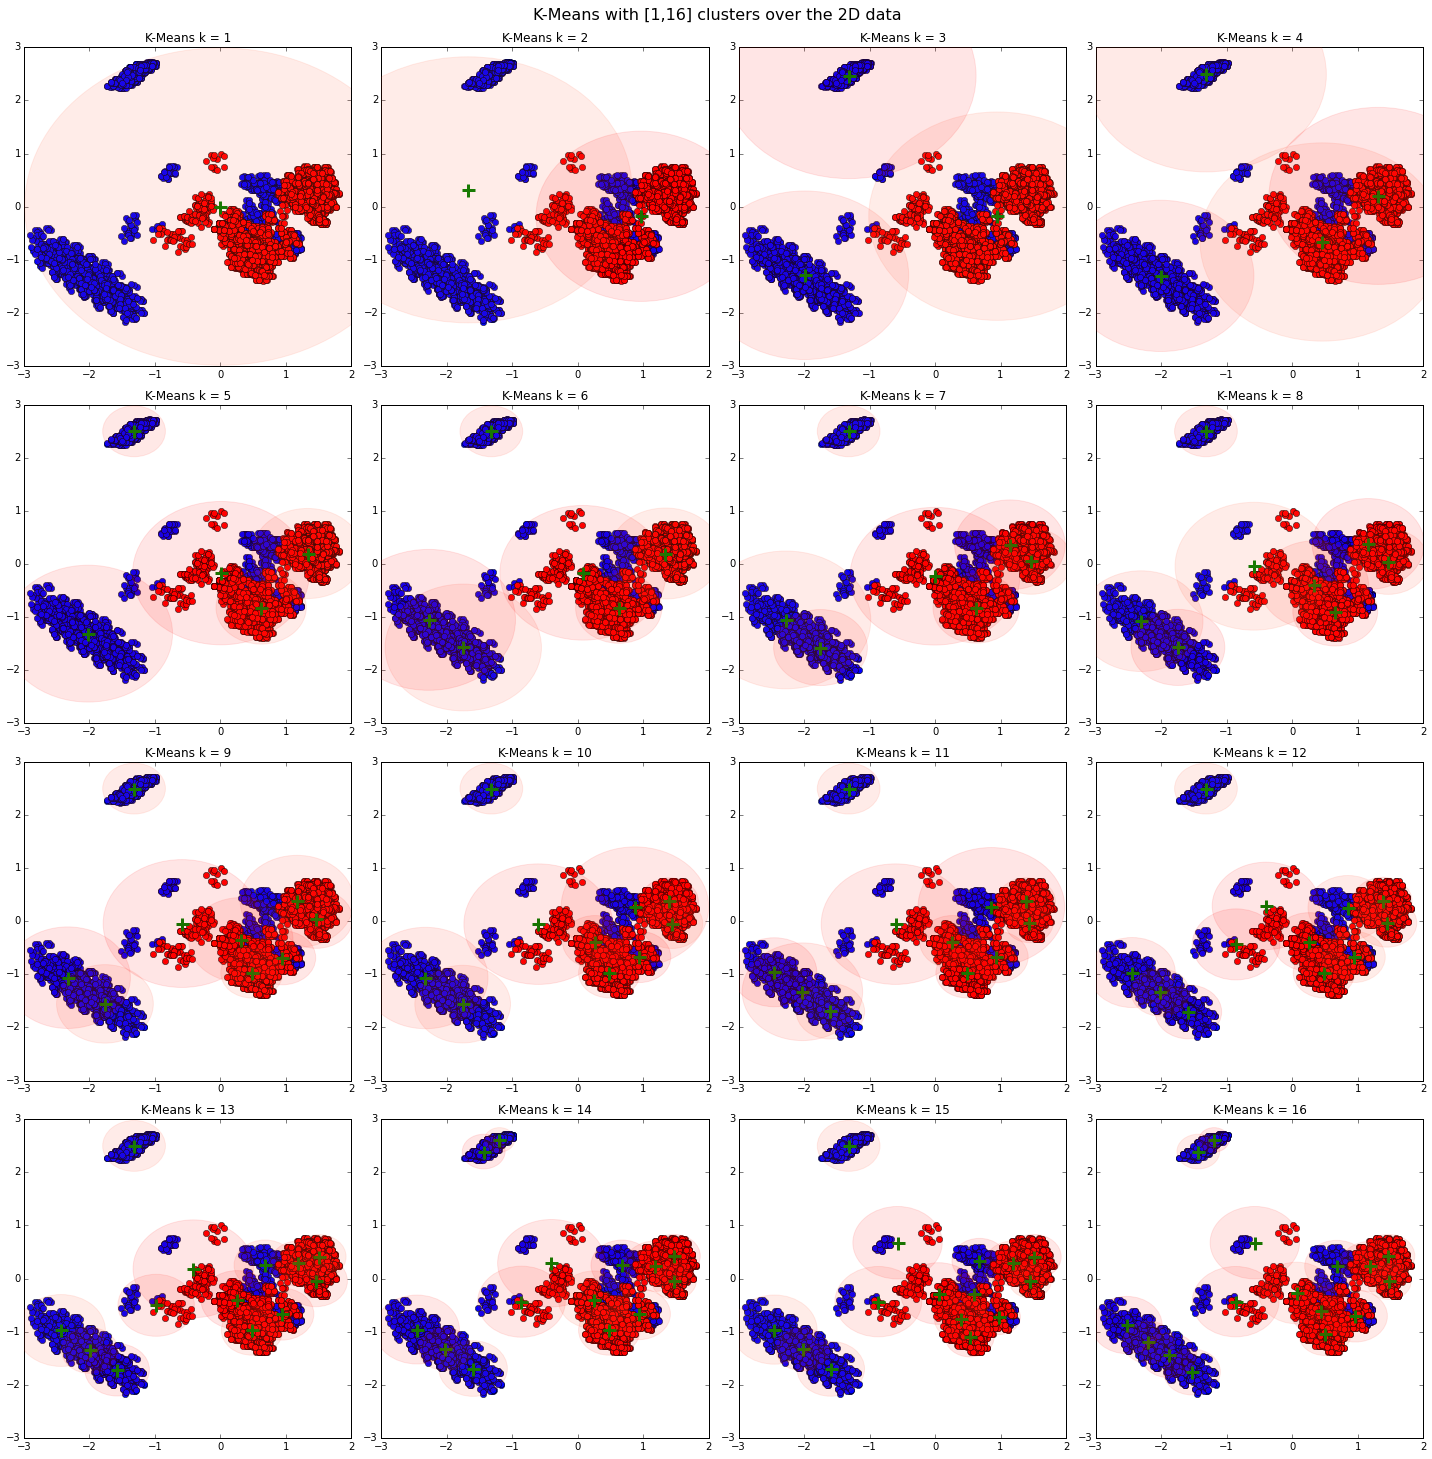

In [6]:
def P3():
### STUDENT START ###
    plt.figure(figsize=(20,20))
    plt.suptitle('K-Means with [1,16] clusters over the 2D data', fontsize = 16, y = 1.01)

    for k in range (1, 17):
        # fit k-means model
        kmeans = KMeans(init = 'k-means++', n_clusters = k, n_init = 10)
        kmeans.fit(pca_train)

        # add sub-plot
        p = plt.subplot(4, 4, k)
        
        # plot points
        plt.plot(poison[:, 0], poison[:, 1], 'bo')
        plt.plot(not_poison[:, 0], not_poison[:, 1], 'ro')

        # plot centroids
        p.plot(
            kmeans.cluster_centers_[:,0], 
            kmeans.cluster_centers_[:,1], 
            color='green', linewidth=0, zorder=3,
            marker='+', markersize=13, markeredgewidth=3)

        colors = iter(plt.cm.rainbow(np.linspace(0.9, 1, k)))
        # plot circles around centroid covering the furtherst point from each centroid
        for x in range(0, kmeans.cluster_centers_.shape[0]):

            # calculate farthest point usin Euclidean distance available in metrics
            r = np.amax(
                metrics.pairwise.euclidean_distances(
                    kmeans.cluster_centers_[x], 
                    pca_train[kmeans.labels_ == x]))

            # add circle to plot
            p.add_artist(
                plt.Circle(
                    xy = (kmeans.cluster_centers_[x,0], kmeans.cluster_centers_[x,1]), 
                    radius=r, alpha=0.1, zorder = 3,
                    color = next(colors)))

        # Add a title
        plt.title('K-Means k = {}'.format(k))

    plt.tight_layout()
    plt.show()
### STUDENT END ###

P3()

**(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').**

/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:1516: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


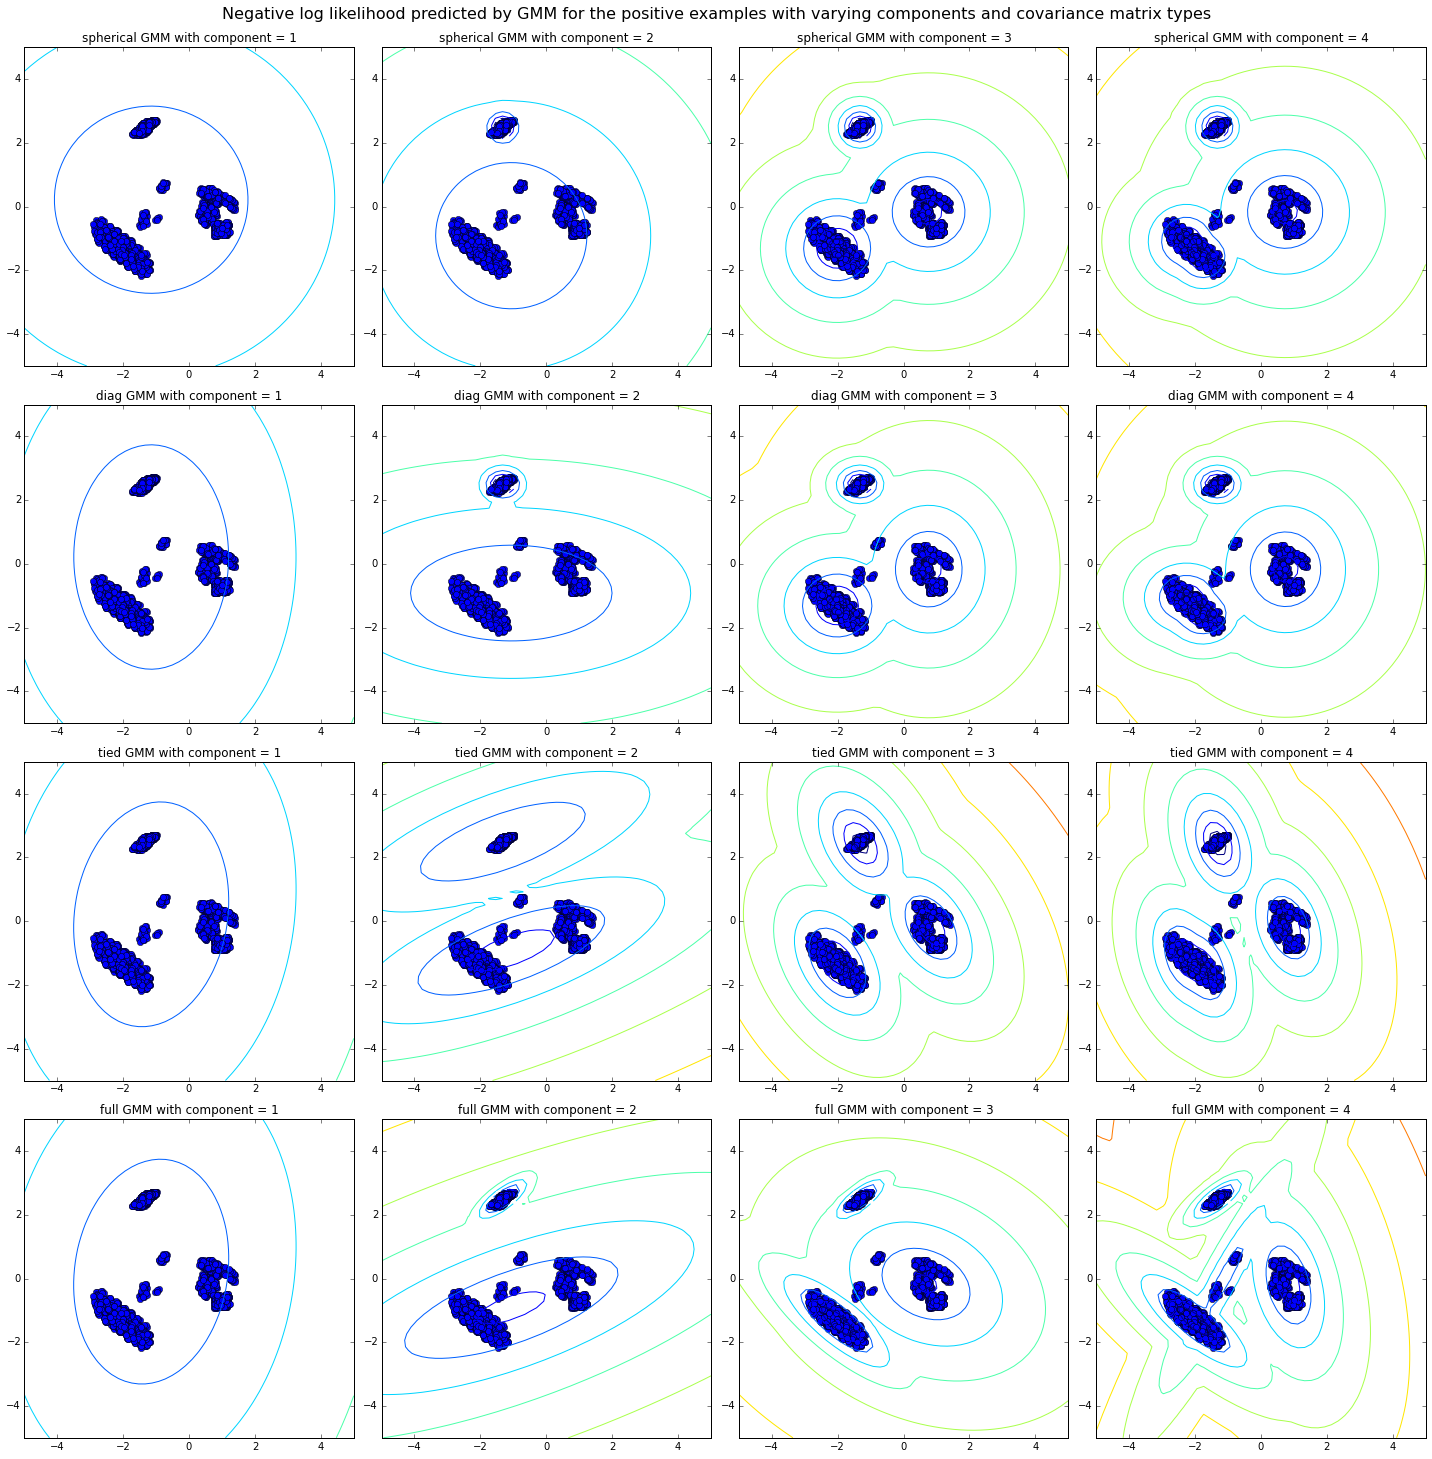

In [7]:
def P4():
### STUDENT START ###
    plt.figure(figsize=(20,20))
    plt.suptitle(
        'Negative log likelihood predicted by GMM for the positive examples with varying components and covariance matrix types', 
        fontsize = 16, y = 1.01)

    covariance_types = ['spherical', 'diag', 'tied', 'full']

    # vary each covariance matrix type
    for i, covariance_type in enumerate(covariance_types):
        # vary for components [1, 4]
        for comp in range(1, 5):
            plt.subplot(4, 4, (4*i) + comp)

            # fit a Gaussian Mixture Model with n components on positive examples (poison)
            clf = GMM(n_components = comp, covariance_type = covariance_type)
            clf.fit(poison)

            # display predicted scores by the model as a contour plot
            x = np.linspace(-5.0, 5.0)
            y = np.linspace(-5.0, 5.0)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -clf.score_samples(XX)[0]
            Z = Z.reshape(X.shape)

            # plotting contour
            CS = plt.contour(X, Y, Z, norm = LogNorm(vmin = 1.0, vmax = 1000.0), levels = np.logspace(0, 3, 10))
            plt.plot(poison[:,0], poison[:,1], 'bo', zorder = -1)
            plt.title(covariance_type + " GMM with component = " +  str(comp))

    plt.tight_layout()
    plt.show()
### STUDENT END ###

P4()

**(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?**

--------------------------------------------------------------------------------
accuracy of GMM correctly predicting a poisonous mushroom is 95.11%
--------------------------------------------------------------------------------


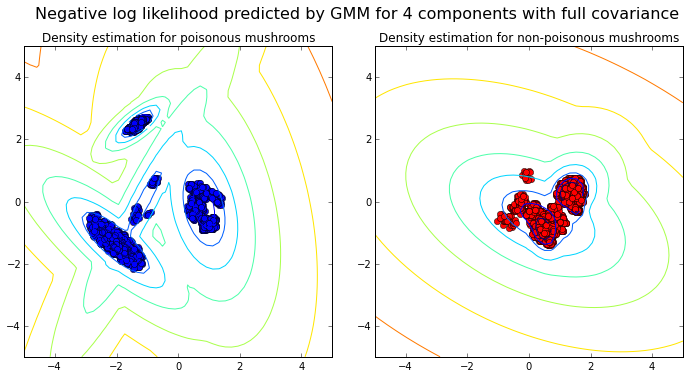

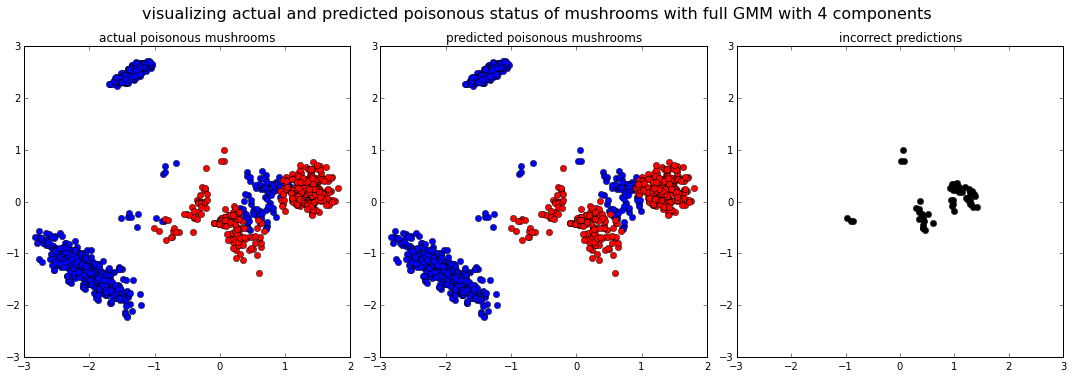

In [8]:
def P5():
### STUDENT START ###

    print "-" * 80

    # transform test data using the model fit on training data
    pca_test = pca.transform(test_data)

    # fit GMM and predict for positive examples
    pos_gmm = GMM(n_components = 4, covariance_type = 'full')
    pos_gmm.fit(poison)

    # fit GMM and predict for negative examples
    neg_gmm = GMM(n_components = 4, covariance_type = 'full')
    neg_gmm.fit(not_poison)
    
    # score both the positive and negative models
    pos_score = pos_gmm.score(pca_test)
    neg_score = neg_gmm.score(pca_test)
    
    # predict based on the larger of the two and if they tie default to poisonous
    predict_labels = (pos_score >= neg_score).astype(int)

    # calculate accuracy
    acc = np.mean(predict_labels == test_labels)    
    print "accuracy of GMM correctly predicting a poisonous mushroom is {:.2%}".format(acc)
    
    print "-" * 80

    # visualizations to understand what's happening

    def plot_neg_lg_lklhd_gmm(gmm):
        x = np.linspace(-5.0, 5.0)
        y = np.linspace(-5.0, 5.0)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -gmm.score_samples(XX)[0]
        Z = Z.reshape(X.shape)
        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))

    # plotting negative log likelihood
    plt.figure(figsize = (10, 5))
    plt.suptitle(
        'Negative log likelihood predicted by GMM for 4 components with full covariance', 
        fontsize = 16, y = 1.04)

    # for poisonous mushrooms
    plt.subplot(1, 2, 1)
    plot_neg_lg_lklhd_gmm(pos_gmm)
    plt.plot(poison[:,0], poison[:,1], 'bo', zorder=-1)
    plt.title("Density estimation for poisonous mushrooms")

    # for non-poisonous mushrooms
    plt.subplot(1, 2, 2)
    plot_neg_lg_lklhd_gmm(neg_gmm)
    plt.plot(not_poison[:,0], not_poison[:,1], 'ro', zorder=-1)
    plt.title("Density estimation for non-poisonous mushrooms")
    
    plt.tight_layout()
    plt.show()
        
    # plotting the predictions
    plt.figure(figsize=(15,5))
    plt.suptitle(
        'visualizing actual and predicted poisonous status of mushrooms with full GMM with 4 components',
        fontsize = 16, y = 1.04)

    # actual poisonous mushrooms
    plt.subplot(1, 3, 1)
    plt.plot(pca_test[test_labels==1,0], pca_test[test_labels==1,1], 'bo', label = 'poison')
    plt.plot(pca_test[test_labels==0,0], pca_test[test_labels==0,1], 'ro', label = 'non-poison')
    plt.title("actual poisonous mushrooms")

    plt.subplot(1, 3, 2)
    plt.plot(pca_test[predict_labels==1,0], pca_test[predict_labels==1,1], 'bo', label = 'poison')
    plt.plot(pca_test[predict_labels==0,0], pca_test[predict_labels==0,1], 'ro', label = 'non-poison')
    plt.title("predicted poisonous mushrooms")

    plt.subplot(1, 3, 3)
    plt.plot(pca_test[predict_labels!=test_labels,0], pca_test[predict_labels!=test_labels,1], 'ko')
    plt.xlim(-3, 3); 
    plt.ylim(-3, 3)
    plt.title("incorrect predictions")

    plt.tight_layout()
    plt.show()

### STUDENT END ###

P5()

**(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:**

**( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters**

**You should vary the number of PCA components, the number of GMM components, and the covariance type.**

In [9]:
def P6():
### STUDENT START ###  
    def get_num_parameters(num_features, num_components, covariance_type):
        # number of classes (2 - poison/non-poison)
        num_classes = 2 

        # total number of parameter in mean vector
        num_param = num_features * num_components 

        # set number of covariance parameter for each covariance type
        # for D components in p dimensions
        if covariance_type == 'spherical':
            # diagonal matrix with zeroes on the off diagonal and one value on the diagonal 
            # shape of component: a sphere
            num_param += 1 * num_components # D

        if covariance_type == 'diag':
            # diagonal matrix with zeroes on the off diagonal and different values on each entry of the diagonal
            # shape of component: an ellipse, with axes aligned to the dimension axes
            num_param += num_features * num_components # D*p

        if covariance_type == 'tied':
            # full matrix; fixed across all components
            # shape of component: any ellipse like shape; fixed across all components
            num_param += (num_features + ((num_features * (num_features-1)) / 2)) # [p + p * (p-1) / 2]

        if covariance_type == 'full':
            # a full matrix
            # shape of component: any ellipse like shape
            num_param += num_components * (num_features + ((num_features * (num_features-1)) / 2)) # D * [p + p * (p-1) / 2]

        # return total number of parameters for all classes
        return (num_param * num_classes)

    def get_model_accuracy(num_features, num_components, cov_type):
        pca = PCA(n_components = num_features)                                  # create PCA with n features
        pca_train = pca.fit_transform(train_data)                               # fit and transform training data
        poison = pca_train[np.where(train_labels == 1)]                         # poison/positive data
        not_poison = pca_train[np.where(train_labels == 0)]                     # non-poison/negative data
        pos_gmm = GMM(n_components=num_components, covariance_type=cov_type)    # GMM for poison data
        pos_gmm.fit(poison)                                                     # fit GMM for positive data
        neg_gmm = GMM(n_components=num_components, covariance_type=cov_type)    # GMM for non-poison data
        neg_gmm.fit(not_poison)                                                 # fit GMM for negative data
        pos_score = pos_gmm.score(pca.transform(test_data))                     # log probabilities on test for positive  
        neg_score = neg_gmm.score(pca.transform(test_data))                     # log probabilities on test for negative
        predict_labels = (pos_score >= neg_score).astype(int)                   # choose larger of the probabilities   

        return np.mean(predict_labels == test_labels)

    # main function
    # list of different covariance types
    covariance_types = ['spherical','diag','tied','full']   

    # parameters (to store c), details (to store parameter combinations),
    # accuracies (to store different accuracies)
    features = []        # number of dimensions/features
    components = []      # number of GMM components
    parameters = []      # number of parameters
    types = []           # covariance types
    accuracies = []      # accuracy

    print 'starting experiments'

    print "-" * 80
    print "{:15} | {:10} | {:15} | {:10} | {:15}".format("pca components", "covar type", "gmm components", "parameters", "accuracy")
    print "-" * 80

    # iterate through different  pca components
    # to solve for maximum value of p that can give parameters of 50 for spherical type 
    # ((p + 1) * D) * 2 = 50 => p maximizes when D =1
    # ((p + 1) * 2) = 50 => p-max = 24
    for pca_comp in range(1, 25):
        # iterate through different covariance types
        for cov_type in covariance_types:
            gmm_comp = 1                                                     # start with gmm_components = 1
            num_param = get_num_parameters(pca_comp, gmm_comp, cov_type)     # calculate number of parameters

            while num_param <= 50:
                accuracy = get_model_accuracy(pca_comp, gmm_comp, cov_type)
                
                features.append(pca_comp)
                components.append(gmm_comp)
                parameters.append(num_param)
                accuracies.append(accuracy)
                types.append(cov_type)
                
                print "{:15} | {:10} | {:15} | {:10} | {:.4f}".format(pca_comp, cov_type, gmm_comp, num_param, accuracy)
                
                # Update number of components
                gmm_comp += 1
                num_param = get_num_parameters(pca_comp, gmm_comp, cov_type)

    print "-" * 80
    print 'end of experiments'

    # find best parameter combination
    idx = np.argmax(accuracies)
    print "\n"
    print "Best fit with number of parameters <= 50 is \n{} dimensions \n{} component {} GMM \n{} parameters and \n{:.2%} accuracy" \
    .format(features[idx], components[idx], types[idx], parameters[idx], accuracies[idx])

    ### STUDENT END ###
    
P6()

starting experiments
--------------------------------------------------------------------------------
pca components  | covar type | gmm components  | parameters | accuracy       
--------------------------------------------------------------------------------
              1 | spherical  |               1 |          4 | 0.8443
              1 | spherical  |               2 |          8 | 0.8995
              1 | spherical  |               3 |         12 | 0.9030
              1 | spherical  |               4 |         16 | 0.9137
              1 | spherical  |               5 |         20 | 0.9066
              1 | spherical  |               6 |         24 | 0.9084
              1 | spherical  |               7 |         28 | 0.9119
              1 | spherical  |               8 |         32 | 0.9101
              1 | spherical  |               9 |         36 | 0.9101
              1 | spherical  |              10 |         40 | 0.9101
              1 | spherical  |              11 | 